In [59]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import env
import csv

In [2]:
df = pd.read_csv('zillow.csv')

In [3]:
pd.set_option('display.max_columns', None) 


In [4]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [5]:
df = remove_dup_col(df)

In [6]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [7]:
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

In [8]:
def drop_col(df):
        df = df.drop(columns = ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'propertycountylandusecode',
                            'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 
                            'censustractandblock', 'transactiondate', 'assessmentyear',
                            'roomcnt', 'regionidcounty'])
        return df

In [9]:
df = drop_col(df)
df.head()

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
0,12177905,2288172,3,4,8.0,2376.0,6037,2.0,34245180,-118240722,13038.0,LCR110000*,1,1970.0,108918.0,145143,36225,1777.51,-0.103410
1,10887214,1970746,3,3,8.0,1312.0,6037,2.0,34185120,-118414640,278581.0,LAR3,1,1964.0,73681.0,119407,45726,1533.89,0.006940
2,12095076,781532,3,4,9.0,2962.0,6037,2.0,34145202,-118179824,63000.0,PSR2,1,1950.0,276684.0,773303,496619,9516.26,-0.001011
3,12069064,870991,1,2,5.0,738.0,6037,NaN,34149214,-118239357,4214.0,GLR4YY,1,1922.0,18890.0,218552,199662,2366.08,0.101723
4,12790562,1246926,3,4,9.0,3039.0,6037,2.0,33960230,-118006914,20028.0,WHRE20000*,1,1970.0,177527.0,220583,43056,3104.19,-0.040966


In [10]:
x = df['landtaxvaluedollarcnt']
y = df['lotsizesquarefeet']
ols_model = ols('lotsizesquarefeet ~ landtaxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['landtaxvaluedollarcnt']])

In [11]:
df.lotsizesquarefeet = np.where(df.lotsizesquarefeet.isna(), df.yhat, df.lotsizesquarefeet)

In [12]:
def impute_values(df):
    sqfeet = df.calculatedfinishedsquarefeet.median()
    df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(sqfeet)
    
    structuretaxvalue = df.structuretaxvaluedollarcnt.median()
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(structuretaxvalue)
    
    taxvalue = df.taxvaluedollarcnt.median()
    df.taxvaluedollarcnt = df.taxvaluedollarcnt.fillna(taxvalue)
    
    landtaxvalue = df.landtaxvaluedollarcnt.median()
    df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(landtaxvalue)
    
    return df

In [13]:
x = df['taxvaluedollarcnt']
y = df['taxamount']
ols_model = ols('lotsizesquarefeet ~ taxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['taxvaluedollarcnt']])

In [14]:
# use y when we have y, if y is NaN, use yhat
df.taxamount = np.where(df.taxamount.isna(), df.yhat, df.taxamount)

In [15]:
df.fillna(value=pd.np.nan, inplace=True)
df = df.dropna()
def drop_col2(df): #Drop additional columns that are no longer of use. 
        df = df.drop(columns = ['taxamount', 'yhat'])
        return df

df = drop_col2(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45631 entries, 0 to 46941
Data columns (total 18 columns):
parcelid                        45631 non-null int64
id                              45631 non-null int64
bathroomcnt                     45631 non-null int64
bedroomcnt                      45631 non-null int64
buildingqualitytypeid           45631 non-null float64
calculatedfinishedsquarefeet    45631 non-null float64
fips                            45631 non-null int64
heatingorsystemtypeid           45631 non-null float64
latitude                        45631 non-null int64
longitude                       45631 non-null int64
lotsizesquarefeet               45631 non-null float64
propertyzoningdesc              45631 non-null object
unitcnt                         45631 non-null int64
yearbuilt                       45631 non-null float64
structuretaxvaluedollarcnt      45631 non-null float64
taxvaluedollarcnt               45631 non-null int64
landtaxvaluedollarcnt         

In [17]:
df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] =df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']].astype('int64')

In [21]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
                   for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0.0,0,0.0,0,0,0.0,0.0,0,0,0,206352.0,0.0,0,0.0,0.0,0.0,0.000000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0.0,0,0.0,0,0,0.0,0.0,0,0,0,149372.0,0.0,0,0.0,0.0,0.0,0.000000


In [23]:
new_df = add_upper_outlier_columns(df, k=4)

In [24]:
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())

~~~
parcelid_outliers
count    1.600000e+01
mean     1.497421e+08
std      4.776622e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497419e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    46.000000
mean      1.391304
std       0.714244
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsqua

In [25]:
new_df = new_df[(new_df.logerror_outliers ==0) & (new_df.lotsizesquarefeet_outliers == 0)]

In [26]:
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())

~~~
parcelid_outliers
count    1.500000e+01
mean     1.497423e+08
std      4.906149e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497421e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    38.000000
mean      1.447368
std       0.760418
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsqua

In [27]:
new_df = new_df[(new_df.bathroomcnt_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0)]
        
        
        
    

In [28]:
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())

~~~
parcelid_outliers
count    1.500000e+01
mean     1.497423e+08
std      4.906149e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497421e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count    0.0
mean     NaN
std   

In [29]:
new_df = new_df[(new_df.structuretaxvaluedollarcnt_outliers == 0) & (new_df.taxvaluedollarcnt_outliers == 0) & (new_df.landtaxvaluedollarcnt_outliers == 0)]
        
        
        
    

In [48]:
new_df.describe()

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror
count,3.850000e+04,3.850000e+04,38500.000000,38500.000000,38500.000000,38500.000000,38500.0,38500.000000,3.850000e+04,3.850000e+04,38500.000000,38500.0,38500.000000,38500.000000,3.850000e+04,3.850000e+04,38500.000000
mean,1.191102e+07,1.500122e+06,2.169506,3.010156,6.477377,1654.542104,6037.0,3.642779,3.410951e+07,-1.182501e+08,12209.277766,1.0,1962.998286,158681.735558,3.996430e+05,2.409613e+05,0.000020
std,2.731404e+06,8.606605e+05,0.867487,0.931050,1.632956,702.273590,0.0,2.467115,2.235806e+05,2.180337e+05,12579.538707,0.0,23.814059,114140.896475,3.077212e+05,2.321183e+05,0.104401
min,1.071186e+07,1.406000e+03,1.000000,1.000000,1.000000,152.000000,6037.0,2.000000,3.333953e+07,-1.188892e+08,736.000000,1.0,1878.000000,181.000000,3.254000e+03,1.610000e+02,-4.655420
25%,1.118922e+07,7.647012e+05,2.000000,2.000000,6.000000,1165.000000,6037.0,2.000000,3.395403e+07,-1.184132e+08,5867.000000,1.0,1949.000000,80939.000000,1.803740e+05,6.252100e+04,-0.028546
50%,1.188633e+07,1.501595e+06,2.000000,3.000000,6.000000,1491.000000,6037.0,2.000000,3.409130e+07,-1.182592e+08,7286.000000,1.0,1958.000000,130177.000000,3.289190e+05,1.799910e+05,0.004660
75%,1.252270e+07,2.246601e+06,3.000000,4.000000,8.000000,1964.000000,6037.0,7.000000,3.419376e+07,-1.181037e+08,11388.500000,1.0,1981.000000,203470.250000,5.248842e+05,3.338938e+05,0.036078
max,1.676560e+08,2.982188e+06,7.000000,9.000000,12.000000,5271.000000,6037.0,20.000000,3.475508e+07,-1.176539e+08,72208.000000,1.0,2016.000000,717211.000000,1.912075e+06,1.425000e+06,0.305291


In [39]:
new_df.columns
new_df = new_df.drop(columns= ['parcelid_outliers', 'id_outliers', 'bathroomcnt_outliers',
       'bedroomcnt_outliers', 'buildingqualitytypeid_outliers',
       'calculatedfinishedsquarefeet_outliers', 'fips_outliers',
       'heatingorsystemtypeid_outliers', 'latitude_outliers',
       'longitude_outliers', 'lotsizesquarefeet_outliers', 'unitcnt_outliers',
       'yearbuilt_outliers', 'structuretaxvaluedollarcnt_outliers',
       'taxvaluedollarcnt_outliers', 'landtaxvaluedollarcnt_outliers',
       'logerror_outliers'])

In [41]:
train, test = train_test_split(new_df, test_size=.30)

In [42]:
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet', 'propertyzoningdesc',
       'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror'],
      dtype='object')

In [33]:
def scale_uniform(train, test, column_list):
    scaler = QuantileTransformer(output_distribution='uniform', random_state=123)
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

In [34]:
def scale_minmax(train, test, column_list):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler


In [66]:
X_train = train.drop(columns ='logerror')
y_train = train[['logerror']]
X_test = test.drop(columns ='logerror')
y_test = test[['logerror']]
y_train

,logerror
34440,-0.021129
40201,0.082885
35725,0.094751
12666,-0.000302
8735,0.242130
1213,0.051874
3838,-0.010174
41547,-0.076775
32336,0.109351
32851,0.014234


In [56]:
def target_cluster(y_train,X_train):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train






In [75]:
train = target_cluster(y_train,X_train)

In [80]:
train.groupby(['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror
cluster,,,,,,,,,,,,,,,,,
4,1.166100e+07,8.914779e+05,2.142857,2.714286,6.428571,1768.000000,6037.0,4.142857,3.408538e+07,-1.182720e+08,15640.857143,1.0,1966.285714,156130.571429,359480.857143,203350.285714,-2.725318
3,1.171520e+07,1.478834e+06,1.869369,2.684685,6.099099,1545.986486,6037.0,4.680180,3.408375e+07,-1.183168e+08,10671.261261,1.0,1945.180180,146511.022523,463945.391892,317434.369369,-0.573393
0,1.190297e+07,1.524348e+06,2.039873,2.875099,6.290203,1586.090309,6037.0,3.950092,3.410801e+07,-1.182593e+08,11667.756800,1.0,1956.237127,148113.128334,392361.690256,244248.561922,-0.114674
1,1.193440e+07,1.501338e+06,2.191061,3.027447,6.533357,1652.621937,6037.0,3.542286,3.411402e+07,-1.182444e+08,12395.140531,1.0,1965.091015,161066.492568,400282.181422,239215.688854,0.006580
2,1.185387e+07,1.517991e+06,2.207571,3.067018,6.371703,1744.353708,6037.0,3.845175,3.409620e+07,-1.182607e+08,12120.427242,1.0,1959.179957,156646.026063,402576.871859,245930.845796,0.138666


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26587f98>,
      dtype=object)

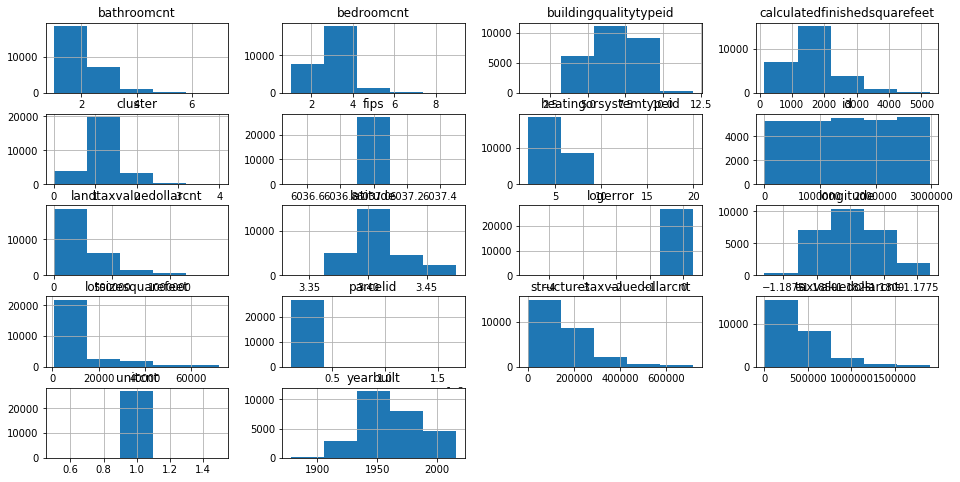

In [82]:
train.hist(figsize=(16, 8), bins=5, log=False)

In [81]:
for i in train[col].unique().tolist():
            mean = train[train[col] == i].logerror.mean()
            std = train[train[col] == i].logerror.std()
            x = np.linspace(mean-.5,mean+.5,1000)
            y = norm.pdf(x, loc=mean, scale=std)    # for example
            plt.plot(x,y, label = i)

NameError: name 'zillow' is not defined

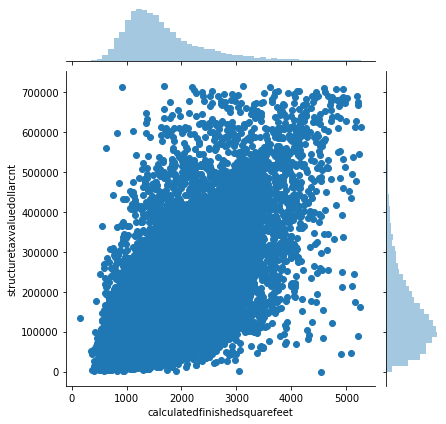

In [86]:
sns.jointplot(data=train, x='calculatedfinishedsquarefeet', y='structuretaxvaluedollarcnt')

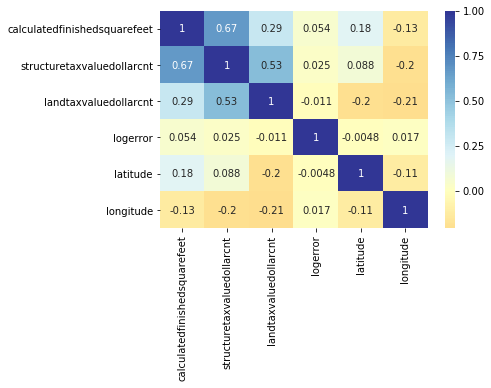

In [97]:
corr1 = train[['calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror', 'latitude', 'longitude' ]]

sns.heatmap(corr1.corr(), cmap='RdYlBu', annot=True, center=0)